<a href="https://colab.research.google.com/github/namanwahi/notebooks/blob/main/tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
% pip install shap
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import shap
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
N_BINS = 7
INPUT_SIZE = 15

In [3]:
X, y_c = make_regression(
    n_samples=10000,
    n_features=INPUT_SIZE,
    n_informative=6,
    bias=123.43,
)


discretizer = KBinsDiscretizer(
    n_bins=N_BINS,
    encode="onehot-dense",
    strategy="quantile",
)
y = discretizer.fit_transform(y_c.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5)

X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")
bin_edges = discretizer.bin_edges_[0].astype("float32")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Bin edges ", bin_edges)

(9995, 15)
(9995, 7)
(5, 15)
(5, 7)
Bin edges  [-363.95786   -19.878597   47.898735   99.93195   148.68092   200.53926
  270.78287   626.67914 ]


In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE,)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(N_BINS, activation="softmax"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=1,
    batch_size=512,
)

20/20 [==============================] - 0s 2ms/step - loss: 2.0305


In [6]:
predictions = model.predict(X_test)
print(predictions.shape)

(5, 7)


In [7]:
print("Probability density", predictions[0].tolist())

Probability density [0.3422620892524719, 0.0709964781999588, 0.036634381860494614, 0.13245710730552673, 0.10934560000896454, 0.18313659727573395, 0.12516780197620392]


In [8]:
quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=predictions[0]),
    components_distribution=tfp.distributions.Uniform(low=bin_edges[:-1], high=bin_edges[1:])
)

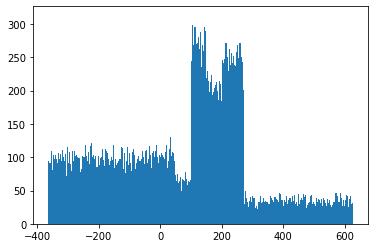

In [9]:
samples = quantized_dist.sample(sample_shape=(100000,))
plt.hist(samples, bins=1000)
plt.show()

In [10]:
quantized_dist.cdf(0.0)
#quantized_dist.quantile(0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.36308485>

In [11]:
def sampled_median(probabilities, bin_edges):
  batched_bin_edges = np.broadcast_to(bin_edges, (probabilities.shape[0], N_BINS + 1))
  quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=probabilities),
    components_distribution=tfp.distributions.Uniform(low=batched_bin_edges[:, :-1], high=batched_bin_edges[:, 1:])
  )

  return np.median(quantized_dist.sample(sample_shape=100000).numpy(), axis=0)


sampled_median(model(X_test), bin_edges)

array([118.66713, 263.04474, 136.63228, 141.7887 , 176.23161],
      dtype=float32)

In [17]:
def quantile(probabilities, bin_edges, quantile):
  bin_widths = np.diff(bin_edges)
  bin_densities = probabilities / bin_widths

  bin_quantiles = tf.cumsum(probabilities, axis=1)

  quantile_bin = tf.searchsorted(bin_quantiles, bin_quantiles[:, -1:] * quantile)
  
  lower_edge = tf.gather_nd(bin_edges, quantile_bin)
  higher_edge = tf.gather_nd(bin_edges, quantile_bin + 1)

  bin_upper_quantile = tf.gather_nd(bin_quantiles, quantile_bin, batch_dims=1)
  bin_density = tf.gather_nd(bin_densities, quantile_bin, batch_dims=1)
  bin_width = tf.gather_nd(bin_widths, quantile_bin)

  residual = ((bin_upper_quantile - quantile) /  bin_density)

  return higher_edge - residual

res = quantile(model(X_test), bin_edges, 0.5)
print(res)

tf.Tensor([118.37316 263.1109  136.26602 141.70653 176.20442], shape=(5,), dtype=float32)


In [18]:
model.add(tf.keras.layers.Lambda(lambda probs: quantile(probs, bin_edges, 0.5)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
_________________________________________________________________
lambda_2 (Lambda)            (None,)                   0         
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________


In [19]:
explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


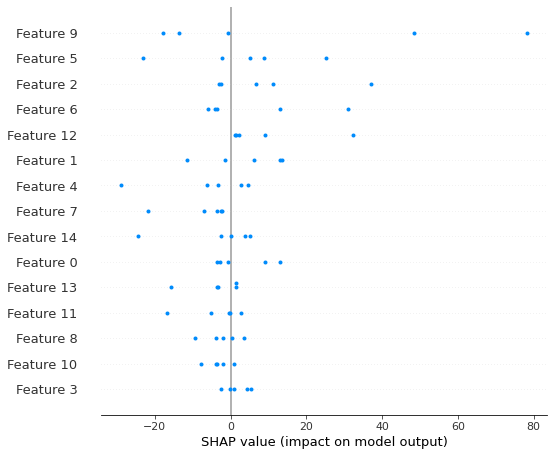

In [20]:
shap.summary_plot(shap_values)

In [ ]:
tf.tile()